In [26]:
import sys
print(sys.version_info)
from io import BytesIO

import math
from sqlalchemy import create_engine
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

print(matplotlib.__version__)

from sklearn.preprocessing import StandardScaler

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
3.1.3


In [28]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
predictor_all = """select distinct * from predictor.pergrid_base"""
predictor_all_df = pd.read_sql(predictor_all, engine)
print(predictor_all_df.shape)
predictor_all_df.columns = map(str.upper, predictor_all_df.columns)

(15310, 23)


In [29]:
import statistics
import seaborn as sns
statistics.median(predictor_all_df['TSR'])

12.0

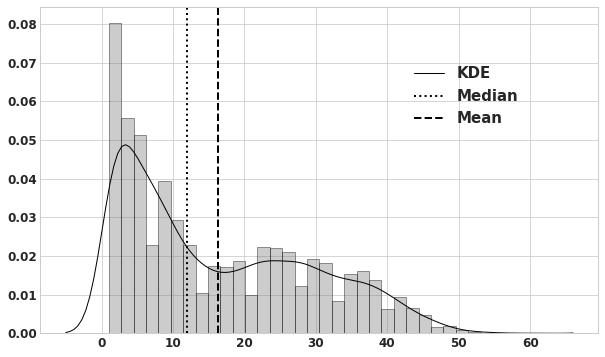

In [32]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
plt.rc('legend', fontsize=15)  
fig = plt.figure(figsize=(10,6))
plt.tight_layout()
sns.distplot(predictor_all_df['TSR'], hist=True, kde=True, axlabel=False,
             hist_kws={"color": "gray",'edgecolor':'black'},
             kde_kws={'linewidth': 1, 'label': 'KDE', "color": "black"})
plt.axvline(x=statistics.median(predictor_all_df['TSR']),linewidth=2, color='black', linestyle = 'dotted', label='Median')
plt.axvline(x=statistics.mean(predictor_all_df['TSR']),linewidth=2, color='black', linestyle = 'dashed', label='Mean')
plt.legend(bbox_to_anchor=(0.88,0.86), loc="upper right")

In [7]:
predictor_all_df_na_remove = predictor_all_df.dropna()
print(predictor_all_df_na_remove.shape)

(13503, 23)


In [8]:
predictor_all_df_na_remove.columns

Index(['GRID_ID', 'AET', 'AI', 'ART', 'EWD', 'FA', 'MAP', 'MAT', 'MPDQ',
       'MTCQ', 'PET', 'PSN', 'RA', 'RMAP', 'RMAT', 'TSN', 'MFDF', 'ALT', 'SHG',
       'MTWQ', 'WKB_GEOMETRY', 'TSR', 'WA'],
      dtype='object')

In [9]:
PRED_VAR= ['AET', 'AI', 'ART', 'EWD', 'FA', 'MAP', 'MAT', 'MPDQ',
       'MTCQ', 'PET', 'PSN', 'RA', 'RMAP', 'RMAT', 'TSN', 'MFDF', 'ALT', 'SHG', 'MTWQ']
pred_dat = predictor_all_df_na_remove[PRED_VAR]

In [10]:
# group variables by hypothesis
var =  ['AET', 'AI', 'ART', 'EWD', 'FA', 'MAP', 'MAT', 'MPDQ',
       'MTCQ', 'PET', 'PSN', 'RA', 'RMAP', 'RMAT', 'TSN', 'MFDF', 'ALT', 'SHG',
       'MTWQ', 'TSR']
dat = predictor_all_df_na_remove[var]

In [12]:
# calcualte spearman correlation coefficient
from scipy.stats import spearmanr 

corr = spearmanr(dat).correlation
corr_sort_abs = pd.DataFrame(corr, columns=var)['TSR'].abs()
corr_sort_abs_df = pd.DataFrame(
    {'feature': var,
    'correlation': corr_sort_abs.tolist()})
corr_sort_abs_df.drop(corr_sort_abs_df.tail(1).index,inplace=True)

In [13]:
# pergrid_base_encoded=pd.get_dummies(pergrid_base_df_na_remove, columns=["hydrogroup"])
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
predictor_all_df_na_remove.loc[: ,'SHG'] = number.fit_transform(predictor_all_df_na_remove['SHG'])

/Users/lianfeng/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
X = predictor_all_df_na_remove[PRED_VAR]

# standarize predictors
ss = StandardScaler(with_mean=True, with_std=True)
X_std = ss.fit_transform(X.values)

Xstd=pd.DataFrame(data=X_std[0:,0:],
                index=X.index,
                columns=PRED_VAR)

In [15]:
y_true = predictor_all_df_na_remove['TSR']

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(Xstd, y_true, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(Xstd, y_true, test_size=0.1, random_state=0)

In [17]:
rf_exp = RandomForestRegressor(n_estimators= 1978, 
                               min_samples_split = 5,
                               min_samples_leaf = 2,
                               max_features = 'sqrt',
                               max_depth = 66,
                               bootstrap = False)
rf_exp.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=66, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1978, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_exp, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

In [19]:
perm_importance = pd.DataFrame(
    {'feature': X_train.columns[perm_sorted_idx],
    'perm_importance': result.importances_mean[perm_sorted_idx].T})

In [20]:
corr_sort_abs_df.shape

(19, 2)

In [21]:
feature_list = list(X_train.columns)
# Get numerical feature importances
importances = list(rf_exp.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 6)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]

sorted_features = [importance[0].upper() for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

In [22]:
rf_importance = pd.DataFrame(
    {'feature': sorted_features,
    'rf_importance': sorted_importances,
    'cum_rf_importance': cumulative_importances
    })

In [23]:
feature_ranked = pd.merge(rf_importance, corr_sort_abs_df, on='feature')

In [24]:
feature_ranked_total = pd.merge(feature_ranked, perm_importance, on='feature')

In [25]:
feature_ranked_total

,feature,rf_importance,cum_rf_importance,correlation,perm_importance
0,AI,0.172265,0.172265,0.782097,0.083630
1,MPDQ,0.152245,0.324510,0.802291,0.069976
2,FA,0.123518,0.448028,0.678510,0.203273
3,MAP,0.114510,0.562538,0.771603,0.048067
4,AET,0.106048,0.668586,0.766400,0.010190
5,PSN,0.055642,0.724228,0.590021,0.024951
6,ALT,0.044109,0.768337,0.564743,0.011154
7,PET,0.040273,0.808610,0.421666,0.015424
8,RA,0.024188,0.832798,0.273367,0.007064
9,MTCQ,0.022757,0.855555,0.115045,0.012364


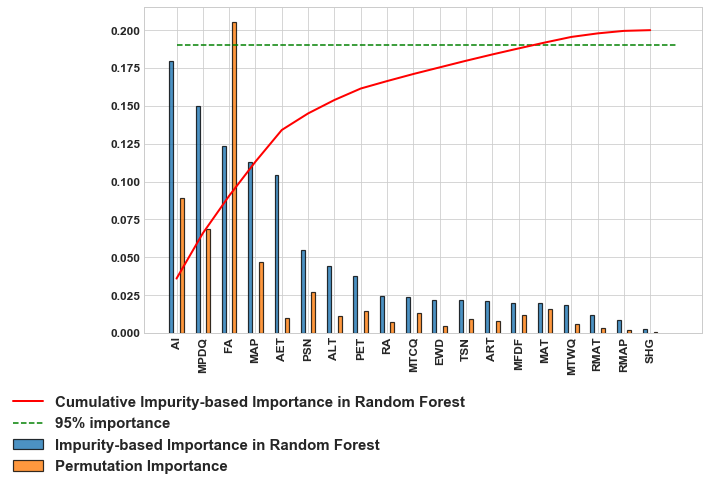

In [565]:
# list of x locations for plotting
x = np.arange(feature_ranked_total.shape[0]) # the label locations

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,6))
plt.tight_layout()

# Make a bar chart
w = 0.3
plt.bar(x-w/1.5, feature_ranked_total['rf_importance'], width=w/2, orientation = 'vertical', alpha=0.8, edgecolor = 'k', linewidth = 1.2)
plt.bar(x+w/1.5, feature_ranked_total['perm_importance'], width=w/2, orientation = 'vertical', alpha=0.8, edgecolor = 'k', linewidth = 1.2)
# plt.bar(x, feature_ranked_total['correlation']/5, width=w/2, orientation = 'vertical', alpha=0.8, edgecolor = 'k', linewidth = 1.2)

# Make a line graph
plt.plot(x, feature_ranked_total['cum_rf_importance']/5, 'r-', linewidth=2)
# Draw line at 95% of importance retained
plt.hlines(y = 0.95/5, xmin=0, xmax=len(sorted_importances), color = 'g', linestyles = 'dashed')

plt.xticks(x, feature_ranked_total['feature'], rotation='vertical')

# 'Spearman Correlation Coefficient'  
plt.legend(['Cumulative Impurity-based Importance in Random Forest', '95% importance','Impurity-based Importance in Random Forest', 'Permutation Importance',], bbox_to_anchor=(0.6,-0.15), loc="upper right")

In [575]:
feature_ranked_total

,feature,rf_importance,cum_rf_importance,correlation,perm_importance
0,AI,0.179342,0.179342,0.782097,0.089231
1,MPDQ,0.149735,0.329077,0.802291,0.068386
2,FA,0.123629,0.452706,0.678510,0.205226
3,MAP,0.112904,0.565610,0.771603,0.046936
4,AET,0.104590,0.670200,0.766400,0.009567
5,PSN,0.054725,0.724925,0.590021,0.026688
6,ALT,0.044386,0.769311,0.564743,0.011469
7,PET,0.037851,0.807162,0.421666,0.014213
8,RA,0.024611,0.831773,0.273367,0.007397
9,MTCQ,0.023408,0.855181,0.115045,0.012864


In [ ]:
# calcualte spearman correlation coefficient
corr = spearmanr(dat).correlation
corr_sort_abs = pd.DataFrame(corr, columns=var)['TSR'].abs()
corr_sort_abs_df = pd.DataFrame(
    {'feature': var,
    'correlation': corr_sort_abs.tolist()})
corr_sort_abs_df.drop(corr_sort_abs_df.tail(1).index,inplace=True)

In [577]:
pred_dat.columns

Index(['AET', 'AI', 'ART', 'EWD', 'FA', 'MAP', 'MAT', 'MPDQ', 'MTCQ', 'PET',
       'PSN', 'RA', 'RMAP', 'RMAT', 'TSN', 'MFDF', 'ALT', 'SHG', 'MTWQ'],
      dtype='object')

Text(0, 0.5, 'Euclidean Distance')

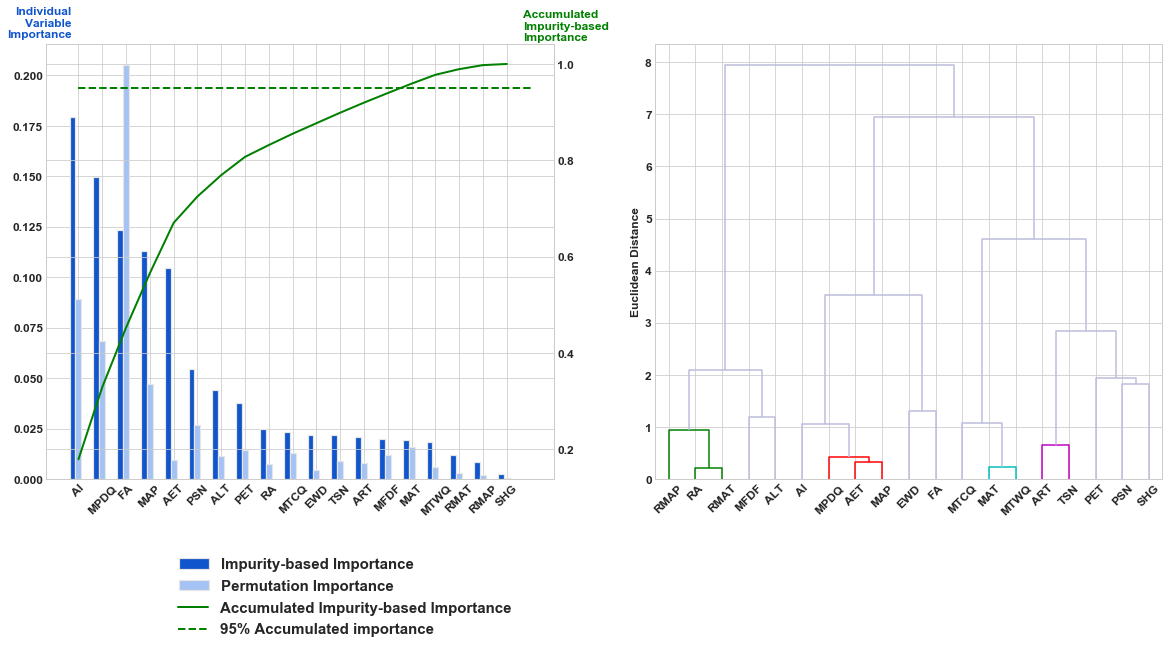

In [605]:
# list of x locations for plotting
x = np.arange(feature_ranked_total.shape[0]) # the label locations
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(121)
# plt.tight_layout()

colors = ['#1155cc', '#a4c2f4','green', 'green']
# Make a bar chart
w = 0.5
ax1.bar(x-w/2, feature_ranked_total['rf_importance'], color=colors[0], width=w/2, orientation = 'vertical', edgecolor = '#E6E6E6', linewidth = 1.2)
ax1.bar(x, feature_ranked_total['perm_importance'], color=colors[1], width=w/2, orientation = 'vertical', edgecolor = '#E6E6E6', linewidth = 1.2)

ax1.legend(['Impurity-based Importance', 'Permutation Importance',], bbox_to_anchor=(0.75,-0.150), loc="upper right")
ax1.set_ylabel('Individual\nVariable\nImportance',fontweight='bold', color=colors[0], rotation='0', ha='right', fontsize=12)
ax1.yaxis.set_label_coords(0.05,1.01)
plt.xticks(x, feature_ranked_total['feature'], rotation=45, fontsize=12)

ax3 = ax1.twinx()
# ax2.bar(x+w/3, feature_ranked_total['correlation'], width=w/3, color=colors[2], orientation = 'vertical',edgecolor = 'k', linewidth = 1.2)
ax3.plot(x, feature_ranked_total['cum_rf_importance'], 'r-', linewidth=2, color=colors[2])
ax3.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = colors[3], linestyles = 'dashed', linewidth=2)
ax3.legend(['Accumulated Impurity-based Importance','95% Accumulated importance'], bbox_to_anchor=(0.944,-0.25), loc="upper right")
ax3.set_ylabel('Accumulated\nImpurity-based\nImportance',fontweight='bold', color=colors[2], rotation=0, ha='left', fontsize=12)
ax3.yaxis.set_label_coords(0.94,1.08)

ax2 = plt.subplot(122)
corr = spearmanr(pred_dat).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, color_threshold=1, labels=PRED_VAR, ax=ax2, leaf_rotation=90, above_threshold_color='#bcbddc')
plt.xticks(rotation=45, fontsize=12)
ax2.set_ylabel('Euclidean Distance',fontweight='bold')

In [597]:
selected_features=['AI', 'EWD', 'FA', 'MAT', 'MPDQ', 'MTCQ', 'PET', 'PSN', 'RA', 'TSN', 'MFDF', 'ALT', 'SHG']

In [600]:
X_train[selected_features]

,AI,EWD,FA,MAT,MPDQ,MTCQ,PET,PSN,RA,TSN,MFDF,ALT,SHG
11071,-0.767615,0.800513,0.281149,-1.606004,-0.414559,-1.404332,-0.673128,-1.133790,0.921434,-0.182151,1.326169,2.157645,0.216003
3741,-1.302805,-0.504883,-1.017102,0.188858,-1.268790,1.062103,1.624330,1.463338,2.332304,-1.345494,-0.417095,0.595000,1.225240
5760,0.606217,0.616363,0.672756,0.059667,1.120893,0.206044,-0.573925,-1.096472,0.527864,-0.405447,0.056299,-0.127758,0.216003
1666,-1.344818,-2.846203,-1.187555,1.165780,-1.068748,0.995064,2.444753,1.035843,-0.678165,-0.091870,-0.377358,0.245634,-0.793233
13717,-0.661113,0.579299,-0.311741,-1.322193,-0.884927,-0.950444,-0.525846,0.520185,0.787943,-0.190839,1.103294,1.666380,-0.793233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14802,-0.591806,0.868432,0.238938,-1.081271,-0.414559,-0.780386,-0.824893,-0.599926,2.014686,-0.521869,1.125754,0.742007,-0.793233
3503,-1.164994,-2.150576,-1.179644,0.940974,-1.005672,0.672171,1.943351,1.088065,-0.540070,0.269679,-0.337620,-0.065761,-0.793233
10813,-1.233766,-0.207942,-1.105856,-0.693402,-1.209318,-0.678502,0.233316,1.320714,-0.415784,0.553472,1.079106,1.280502,0.216003
11871,-1.067054,0.396684,-0.500178,-1.244419,-0.944398,-1.149625,-0.223528,0.225880,2.571668,0.217562,1.360724,1.728669,-1.802470


In [603]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

rf_exp = RandomForestRegressor(n_estimators= 1978, 
                               min_samples_split = 5,
                               min_samples_leaf = 2,
                               max_features = 'sqrt',
                               max_depth = 66,
                               bootstrap = False)
rf_exp.fit(X_train_sel, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=66, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1978, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [604]:
print("Accuracy on test data with features removed: {:.2f}".format(
      rf_exp.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.91


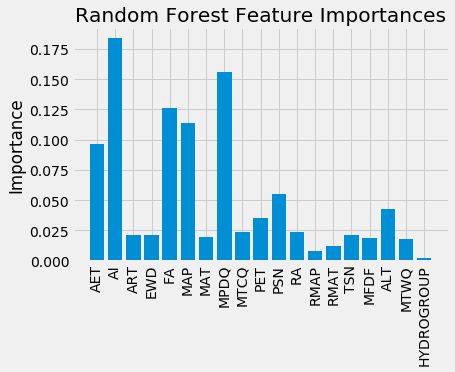

In [78]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
plt.rc('font', size=12)          # controls default text sizes
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
# x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, PRED_VAR, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); 
# plt.xlabel('Variable'); 
plt.title('Random Forest Feature Importances');